### Train and validation split into directories as preprocessing

In [1]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

Get file and unzip

In [2]:
path_cats_and_dogs = f"{getcwd()}/../tmp2/cats-and-dogs.zip"
shutil.rmtree('/tmp')

local_zip = path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [16]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 1500
# 1500

1500
1500


Create directories for training and testing

In [41]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    base_dir = '/tmp/cats-v-dogs'
    os.mkdir(base_dir)

    train_dir = os.path.join(base_dir, 'training')
    test_dir = os.path.join(base_dir, 'testing')
    os.mkdir(train_dir)
    os.mkdir(test_dir)

    # Directory with our training cat/dog pictures
    train_cats_dir = os.path.join(train_dir, 'cats')
    train_dogs_dir = os.path.join(train_dir, 'dogs')

    # Directory with our validation cat/dog pictures
    test_cats_dir = os.path.join(test_dir, 'cats')
    test_dogs_dir = os.path.join(test_dir, 'dogs')
    
    os.mkdir(train_cats_dir)
    os.mkdir(train_dogs_dir)
    os.mkdir(test_cats_dir)
    os.mkdir(test_dogs_dir)
        
except OSError:
    pass

In [49]:
#os.listdir("/tmp/PetImages/Cat/")
#os.path.getsize('/tmp/PetImages/Cat/cat.450.jpg')
#cat_list = os.listdir("/tmp/PetImages/Cat/")
#random.sample(cat_list, len(cat_list))

In [51]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copied to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    file_list = os.listdir(SOURCE)
    shuffle_file_list = random.sample(file_list, len(file_list))
    
    count = 0
    while count < (len(file_list)*SPLIT_SIZE):
        file = shuffle_file_list[count]
        file_path = os.path.join(SOURCE, file)
        copy_path = os.path.join(TRAINING, file)
        if os.path.getsize(file_path) > 0:
            copyfile(file_path, copy_path)
            count += 1
            
    while count < (len(file_list)):
        file = shuffle_file_list[count]
        file_path = os.path.join(SOURCE, file)
        copy_path = os.path.join(TESTING, file)
        if os.path.getsize(file_path) > 0:
            copyfile(file_path, copy_path)
            count += 1


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [52]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 1350
# 1350
# 150
# 150

1350
1350
150
150


Define model (CNN)

In [53]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

Train model through generator

In [55]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/'
train_datagen = ImageDataGenerator(rescale = 1.0/255)

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=10,
                                                    class_mode='binary',
                                                    target_size=(150, 150))    

VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator(rescale = 1.0/255)

# NOTE: YOU MUST USE A BACTH SIZE OF 10 (batch_size=10) FOR THE 
# VALIDATION GENERATOR.
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=10,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))



# Expected Output:
# Found 2700 images belonging to 2 classes.
# Found 300 images belonging to 2 classes.

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [56]:
history = model.fit_generator(train_generator,
                              epochs=2,
                              verbose=1,
                              validation_data=validation_generator)


Epoch 1/2
270/270 [==============================] - 36s 132ms/step - loss: 0.7180 - acc: 0.5963 - val_loss: 0.6071 - val_acc: 0.6933
Epoch 2/2
270/270 [==============================] - 32s 118ms/step - loss: 0.5830 - acc: 0.6948 - val_loss: 0.5531 - val_acc: 0.7200


Plot results

Text(0.5, 1.0, 'Training and validation loss')

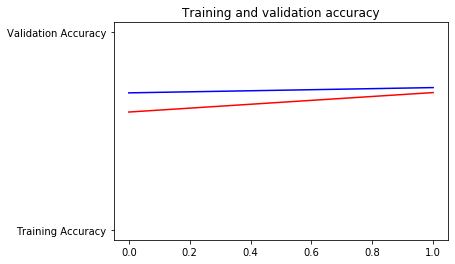

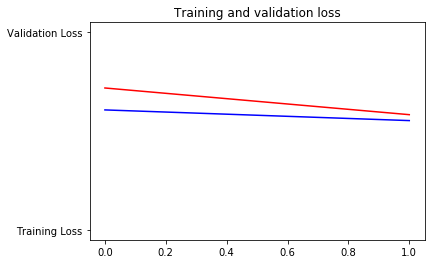

In [57]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)